### **CustomMobileNet - Final version**
* **Model**
  * Architecture Adjustments
    * cfg = [32, 32, 32, (64,2), 64, 64, 64, (128,2), 128, 128, 128, 128, 128, 128, 128, 128, (256,2), 256, 256, 256, (512,2), 512]
    * Residual connection
  * Hyperparameter Tuning
  * Scheduler
  * Data Augmentation Techniques
    * Mix-up
  * Regularization Strategies
    * Drop out
    * Weight initialization
  
* **Best accuracy** :
  * Baseline : [Test set] Average loss: 0.0056, Accuracy: 8426/10000 (84.26%)
  * CustomMobileNet : [Test set] Average loss: 0.0032, Accuracy: 9185/10000 (91.85%) **[ +7.59% ]**

* **FLOPS** : 48,412,672 → 28,963,840 **[ -19,448,832 ]**
* **Total parameters** : 3,217,226 → 1,002,218 **[ -2,215,008 ]**

* **hyperparameter**
  * lr=(0.1), 0.94 * epoch
  * weight_decay=2.5e-3
  * momentum=0.9
  * batch size = 500
  * epoch = 95 + 10 = 105
  * training time : 3544.60

* **optimizer**
  * SGD

* **Data augmentation**
  * **mix-up(alpha = 1.0)**
  * Reference: Facebookreseach mixup-cifar10 (https://github.com/facebookresearch/mixup-cifar10)
  *   
          transforms.Pad(4),
          transforms.RandomHorizontalFlip(),
          transforms.RandomCrop(32),
          transforms.ToTensor()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/ML Project/CustomMobileNet_18_(91.81%)_CustomMobileNet13 batch 500/model"

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Current GPU Index: 0
Current GPU Name: Tesla T4


In [ ]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True,
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False,
                                transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 12499463.25it/s]


Extracting ./cifar_10data/cifar-10-python.tar.gz to ./cifar_10data/


In [ ]:
import math

class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    # with residual connection
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.stride = stride
        self.in_planes = in_planes
        self.out_planes = out_planes

        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        # 입력과 출력의 차원이 다른 경우 Residual connection을 위한 1x1 컨볼루션
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            x = self.shortcut(x)
        out = out + x  # Residual connection 추가
        return out


class MobileNet(nn.Module):
    cfg = [32, 32, 32, (64,2), 64, 64, 64, (128,2), 128, 128, 128, 128, 128, 128, 128, 128, (256,2), 256, 256, 256, (512,2), 512]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layers = self._make_layers(in_planes=16)
        self.linear = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가
        # 가중치 초기화 함수 호출
        self._initialize_weights()

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)

        # 드롭아웃 추가
        out = self.dropout(out)
        out = self.linear(out)
        return out

    # 가중치 초기화 추가
    # from: https://github.com/2KangHo/mobilenet_cifar10_pytorch/blob/master/mobilenet.py
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He 초기화
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # 평균이 0이고 표준편차가 sqrt(2/n)인 정규 분포로 초기화
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                # 배치 정규화 레이어의 가중치를 1로 초기화
                m.weight.data.fill_(1)
                # 배치 정규화 레이어의 편향을 0으로 초기화
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                # FC 레이어의 가중치를 평균이 0이고 표준편차가 0.01인 정규 분포로 초기화
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def test():
    net = MobileNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())

test()

torch.Size([1, 10])


In [ ]:
from torchsummary import summary

model = MobileNet().to(device)

print("CustomMobileNet torchsummary")
summary(model, (3, 32, 32))

CustomMobileNet torchsummary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             144
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 32, 32, 32]             512
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]             512
       BatchNorm2d-8           [-1, 32, 32, 32]              64
             Block-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             288
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           1,024
      BatchNorm2d-13           [-1, 32, 32, 32]              64
          

In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 661.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=9ffb8ab6748015c4c0c2b47cac0f5461b275c0d784c676f7eaa7dbda85cbbebe
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=ec42456ab1d2557d2e0023b726dd1ffb5b413cb7994e0f85ef8939a57fbf985f
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
from fvcore.nn import FlopCountAnalysis

inputs = torch.randn(1, 3, 32, 32).to(device)

flops = FlopCountAnalysis(model, inputs)
print(flops.total())  # 총 FLOPS 출력

28374016


### **95 epoch train**

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=2.5e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.94 ** epoch)

In [ ]:
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
from tqdm import tqdm
import torch
import os

model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

best_accuracy = 0.0
accuracy_list = []
test_loss_list = []
train_loss_list = []

import time
start = time.time()


for epoch in range(95):
    # print(f"{epoch}th epoch starting.")
    batch_num = len(train_loader)

    train_loss_epoch, test_loss, correct = 0, 0, 0

    pbar = tqdm(enumerate(train_loader), total=batch_num, dynamic_ncols=True, position=0, leave=True)
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # MixUp을 적용하여 데이터를 섞음
        mixed_images, target_a, target_b, lam = mixup_data(images, labels, alpha=1.0)

        # 모델에 MixUp된 데이터를 입력으로 전달
        output = model(mixed_images)

        # MixUp된 데이터에 대한 손실을 계산
        train_loss = mixup_criterion(loss_function, output, target_a, target_b, lam)

        train_loss.backward()
        optimizer.step()
        train_loss_epoch += train_loss.item()

        # 현재 배치의 Loss 값 표시
        pbar.set_description(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {train_loss.item():.4f}")

    train_loss_list.append(train_loss_epoch / batch_num)

    scheduler.step()  # 에폭마다 스케줄러 호출
    # 현재 에폭에서의 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}, Current Learning Rate: {current_lr:.6f}")

    with torch.no_grad():
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += loss_function(output, labels).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            total += labels.size(0)

    accuracy = 100. * correct / total
    # test_loss_list.append(test_loss / total)
    test_loss_list.append(test_loss / len(test_loader))
    accuracy_list.append(accuracy)

    # 최고 성능 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_filename = f"best_model_epoch_{epoch+1}.pkt"
        model_save_path = os.path.join(save_path, model_filename)

        torch.save(model.state_dict(), model_save_path)
        print(f"Epoch {epoch + 1}: Best model saved with accuracy: {accuracy:.4f}")

end = time.time()
print("Time elapsed in training is: {}".format(end - start))

Epoch 1, Batch 100, Loss: 2.1352: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 1, Current Learning Rate: 0.094000
Epoch 1: Best model saved with accuracy: 35.3600


Epoch 2, Batch 100, Loss: 1.9770: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 2, Current Learning Rate: 0.088360
Epoch 2: Best model saved with accuracy: 43.7200


Epoch 3, Batch 100, Loss: 1.8446: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch 3, Current Learning Rate: 0.083058
Epoch 3: Best model saved with accuracy: 49.0900


Epoch 4, Batch 100, Loss: 1.6853: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Epoch 4, Current Learning Rate: 0.078075
Epoch 4: Best model saved with accuracy: 54.8300


Epoch 5, Batch 100, Loss: 1.9138: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 5, Current Learning Rate: 0.073390
Epoch 5: Best model saved with accuracy: 62.1500


Epoch 6, Batch 100, Loss: 1.2413: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 6, Current Learning Rate: 0.068987
Epoch 6: Best model saved with accuracy: 62.8300


Epoch 7, Batch 100, Loss: 1.0819: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Epoch 7, Current Learning Rate: 0.064848
Epoch 7: Best model saved with accuracy: 68.4200


Epoch 8, Batch 100, Loss: 1.3563: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 8, Current Learning Rate: 0.060957
Epoch 8: Best model saved with accuracy: 71.3000


Epoch 9, Batch 100, Loss: 1.6721: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 9, Current Learning Rate: 0.057299
Epoch 9: Best model saved with accuracy: 75.0700


Epoch 10, Batch 100, Loss: 0.9691: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Epoch 10, Current Learning Rate: 0.053862
Epoch 10: Best model saved with accuracy: 76.6500


Epoch 11, Batch 100, Loss: 1.2307: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 11, Current Learning Rate: 0.050630
Epoch 11: Best model saved with accuracy: 76.7500


Epoch 12, Batch 100, Loss: 1.1623: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 12, Current Learning Rate: 0.047592
Epoch 12: Best model saved with accuracy: 77.8400


Epoch 13, Batch 100, Loss: 1.7022: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 13, Current Learning Rate: 0.044737
Epoch 13: Best model saved with accuracy: 78.7700


Epoch 14, Batch 100, Loss: 1.1100: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


Epoch 14, Current Learning Rate: 0.042052
Epoch 14: Best model saved with accuracy: 79.8100


Epoch 15, Batch 100, Loss: 0.6603: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 15, Current Learning Rate: 0.039529
Epoch 15: Best model saved with accuracy: 80.8500


Epoch 16, Batch 100, Loss: 1.6710: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 16, Current Learning Rate: 0.037157
Epoch 16: Best model saved with accuracy: 81.1300


Epoch 17, Batch 100, Loss: 0.6640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Epoch 17, Current Learning Rate: 0.034928
Epoch 17: Best model saved with accuracy: 81.7900


Epoch 18, Batch 100, Loss: 1.5349: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 18, Current Learning Rate: 0.032832
Epoch 18: Best model saved with accuracy: 81.8300


Epoch 19, Batch 100, Loss: 1.6505: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 19, Current Learning Rate: 0.030862
Epoch 19: Best model saved with accuracy: 82.8800


Epoch 20, Batch 100, Loss: 1.0408: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


Epoch 20, Current Learning Rate: 0.029011


Epoch 21, Batch 100, Loss: 0.9433: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 21, Current Learning Rate: 0.027270
Epoch 21: Best model saved with accuracy: 82.9000


Epoch 22, Batch 100, Loss: 1.2094: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 22, Current Learning Rate: 0.025634
Epoch 22: Best model saved with accuracy: 83.3900


Epoch 23, Batch 100, Loss: 0.8915: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 23, Current Learning Rate: 0.024096
Epoch 23: Best model saved with accuracy: 84.1700


Epoch 24, Batch 100, Loss: 1.3369: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Epoch 24, Current Learning Rate: 0.022650


Epoch 25, Batch 100, Loss: 1.6018: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 25, Current Learning Rate: 0.021291
Epoch 25: Best model saved with accuracy: 85.1600


Epoch 26, Batch 100, Loss: 0.8113: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 26, Current Learning Rate: 0.020014


Epoch 27, Batch 100, Loss: 0.5822: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 27, Current Learning Rate: 0.018813


Epoch 28, Batch 100, Loss: 1.5711: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 28, Current Learning Rate: 0.017684
Epoch 28: Best model saved with accuracy: 85.3000


Epoch 29, Batch 100, Loss: 0.7369: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 29, Current Learning Rate: 0.016623
Epoch 29: Best model saved with accuracy: 85.4400


Epoch 30, Batch 100, Loss: 0.6949: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 30, Current Learning Rate: 0.015626
Epoch 30: Best model saved with accuracy: 85.4500


Epoch 31, Batch 100, Loss: 1.3380: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 31, Current Learning Rate: 0.014688
Epoch 31: Best model saved with accuracy: 85.5600


Epoch 32, Batch 100, Loss: 1.5031: 100%|██████████| 100/100 [00:31<00:00,  3.23it/s]


Epoch 32, Current Learning Rate: 0.013807
Epoch 32: Best model saved with accuracy: 85.8100


Epoch 33, Batch 100, Loss: 1.0779: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 33, Current Learning Rate: 0.012978
Epoch 33: Best model saved with accuracy: 86.2900


Epoch 34, Batch 100, Loss: 0.9256: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 34, Current Learning Rate: 0.012200
Epoch 34: Best model saved with accuracy: 86.9100


Epoch 35, Batch 100, Loss: 0.5281: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Epoch 35, Current Learning Rate: 0.011468
Epoch 35: Best model saved with accuracy: 87.0700


Epoch 36, Batch 100, Loss: 0.4499: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 36, Current Learning Rate: 0.010780


Epoch 37, Batch 100, Loss: 0.9885: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 37, Current Learning Rate: 0.010133
Epoch 37: Best model saved with accuracy: 87.1600


Epoch 38, Batch 100, Loss: 1.2807: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 38, Current Learning Rate: 0.009525
Epoch 38: Best model saved with accuracy: 87.4700


Epoch 39, Batch 100, Loss: 1.4889: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 39, Current Learning Rate: 0.008953
Epoch 39: Best model saved with accuracy: 87.9700


Epoch 40, Batch 100, Loss: 1.4298: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Epoch 40, Current Learning Rate: 0.008416


Epoch 41, Batch 100, Loss: 1.2550: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 41, Current Learning Rate: 0.007911


Epoch 42, Batch 100, Loss: 1.4862: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 42, Current Learning Rate: 0.007437
Epoch 42: Best model saved with accuracy: 88.0000


Epoch 43, Batch 100, Loss: 1.3117: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 43, Current Learning Rate: 0.006990
Epoch 43: Best model saved with accuracy: 88.1600


Epoch 44, Batch 100, Loss: 1.1210: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 44, Current Learning Rate: 0.006571
Epoch 44: Best model saved with accuracy: 88.5100


Epoch 45, Batch 100, Loss: 1.4158: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 45, Current Learning Rate: 0.006177


Epoch 46, Batch 100, Loss: 0.3929: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch 46, Current Learning Rate: 0.005806


Epoch 47, Batch 100, Loss: 1.0959: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 47, Current Learning Rate: 0.005458


Epoch 48, Batch 100, Loss: 1.4413: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 48, Current Learning Rate: 0.005130
Epoch 48: Best model saved with accuracy: 88.6500


Epoch 49, Batch 100, Loss: 1.0170: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Epoch 49, Current Learning Rate: 0.004822
Epoch 49: Best model saved with accuracy: 89.3700


Epoch 50, Batch 100, Loss: 1.4039: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 50, Current Learning Rate: 0.004533


Epoch 51, Batch 100, Loss: 0.7528: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 51, Current Learning Rate: 0.004261


Epoch 52, Batch 100, Loss: 0.8616: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 52, Current Learning Rate: 0.004005


Epoch 53, Batch 100, Loss: 1.2301: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 53, Current Learning Rate: 0.003765


Epoch 54, Batch 100, Loss: 0.3669: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 54, Current Learning Rate: 0.003539


Epoch 55, Batch 100, Loss: 1.3774: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 55, Current Learning Rate: 0.003327


Epoch 56, Batch 100, Loss: 0.8495: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 56, Current Learning Rate: 0.003127
Epoch 56: Best model saved with accuracy: 89.5400


Epoch 57, Batch 100, Loss: 1.2166: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 57, Current Learning Rate: 0.002940
Epoch 57: Best model saved with accuracy: 89.5500


Epoch 58, Batch 100, Loss: 0.7485: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


Epoch 58, Current Learning Rate: 0.002763


Epoch 59, Batch 100, Loss: 1.2588: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 59, Current Learning Rate: 0.002597
Epoch 59: Best model saved with accuracy: 89.5700


Epoch 60, Batch 100, Loss: 0.7084: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 60, Current Learning Rate: 0.002442
Epoch 60: Best model saved with accuracy: 89.6600


Epoch 61, Batch 100, Loss: 1.3193: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 61, Current Learning Rate: 0.002295
Epoch 61: Best model saved with accuracy: 89.8400


Epoch 62, Batch 100, Loss: 0.6603: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 62, Current Learning Rate: 0.002157


Epoch 63, Batch 100, Loss: 1.3440: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 63, Current Learning Rate: 0.002028


Epoch 64, Batch 100, Loss: 1.3732: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Epoch 64, Current Learning Rate: 0.001906
Epoch 64: Best model saved with accuracy: 89.9400


Epoch 65, Batch 100, Loss: 0.9839: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


Epoch 65, Current Learning Rate: 0.001792


Epoch 66, Batch 100, Loss: 1.3259: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 66, Current Learning Rate: 0.001684
Epoch 66: Best model saved with accuracy: 90.2900


Epoch 67, Batch 100, Loss: 1.0865: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 67, Current Learning Rate: 0.001583
Epoch 67: Best model saved with accuracy: 90.4700


Epoch 68, Batch 100, Loss: 0.9913: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Epoch 68, Current Learning Rate: 0.001488


Epoch 69, Batch 100, Loss: 0.6855: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 69, Current Learning Rate: 0.001399
Epoch 69: Best model saved with accuracy: 90.6300


Epoch 70, Batch 100, Loss: 1.1520: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 70, Current Learning Rate: 0.001315
Epoch 70: Best model saved with accuracy: 90.7900


Epoch 71, Batch 100, Loss: 0.6122: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 71, Current Learning Rate: 0.001236


Epoch 72, Batch 100, Loss: 0.2720: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


Epoch 72, Current Learning Rate: 0.001162


Epoch 73, Batch 100, Loss: 1.0595: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 73, Current Learning Rate: 0.001092


Epoch 74, Batch 100, Loss: 1.2265: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 74, Current Learning Rate: 0.001027


Epoch 75, Batch 100, Loss: 0.5117: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


Epoch 75, Current Learning Rate: 0.000965


Epoch 76, Batch 100, Loss: 1.2919: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Epoch 76, Current Learning Rate: 0.000907


Epoch 77, Batch 100, Loss: 0.1981: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 77, Current Learning Rate: 0.000853


Epoch 78, Batch 100, Loss: 0.2571: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Epoch 78, Current Learning Rate: 0.000802


Epoch 79, Batch 100, Loss: 0.4689: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 79, Current Learning Rate: 0.000754


Epoch 80, Batch 100, Loss: 1.1971: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Epoch 80, Current Learning Rate: 0.000708


Epoch 81, Batch 100, Loss: 1.0496: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


Epoch 81, Current Learning Rate: 0.000666


Epoch 82, Batch 100, Loss: 1.3310: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 82, Current Learning Rate: 0.000626


Epoch 83, Batch 100, Loss: 1.0126: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 83, Current Learning Rate: 0.000588


Epoch 84, Batch 100, Loss: 0.1784: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


Epoch 84, Current Learning Rate: 0.000553
Epoch 84: Best model saved with accuracy: 90.8700


Epoch 85, Batch 100, Loss: 1.3327: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 85, Current Learning Rate: 0.000520


Epoch 86, Batch 100, Loss: 1.2582: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 86, Current Learning Rate: 0.000489
Epoch 86: Best model saved with accuracy: 90.8800


Epoch 87, Batch 100, Loss: 1.3691: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Epoch 87, Current Learning Rate: 0.000459


Epoch 88, Batch 100, Loss: 1.1618: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 88, Current Learning Rate: 0.000432


Epoch 89, Batch 100, Loss: 0.2129: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 89, Current Learning Rate: 0.000406


Epoch 90, Batch 100, Loss: 1.3220: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 90, Current Learning Rate: 0.000382


Epoch 91, Batch 100, Loss: 1.2410: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 91, Current Learning Rate: 0.000359


Epoch 92, Batch 100, Loss: 1.0003: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Epoch 92, Current Learning Rate: 0.000337


Epoch 93, Batch 100, Loss: 1.3056: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 93, Current Learning Rate: 0.000317
Epoch 93: Best model saved with accuracy: 90.9100


Epoch 94, Batch 100, Loss: 1.1541: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Epoch 94, Current Learning Rate: 0.000298
Epoch 94: Best model saved with accuracy: 90.9200


Epoch 95, Batch 100, Loss: 0.1755: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 95, Current Learning Rate: 0.000280
Epoch 95: Best model saved with accuracy: 91.0100
Time elapsed in training is: 3208.5350937843323


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'Test Loss': test_loss_list,
    'Train Loss' : train_loss_list
})

df.to_csv('/content/drive/MyDrive/ML Project/CustomMobileNet_18_CustomMobileNet13 batch 500/metrics.csv', index=False)

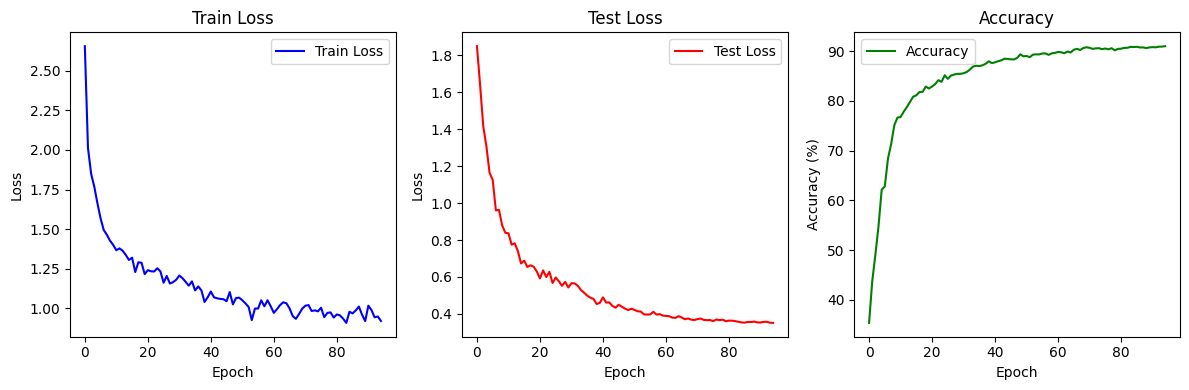

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/ML Project/CustomMobileNet_18_CustomMobileNet13 batch 500/metrics.csv')

# 그래프 크기 설정
plt.figure(figsize=(12, 4))

# Train Loss
plt.subplot(1, 3, 1)
plt.plot(df['Train Loss'], label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

# Test Loss
plt.subplot(1, 3, 2)
plt.plot(df['Test Loss'], label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(df['Accuracy'], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.savefig('/content/drive/MyDrive/ML Project/CustomMobileNet_18_CustomMobileNet13 batch 500/Loss_Accuracy_plot.png')

In [ ]:
model = MobileNet().to(device)

# 저장된 Best 가중치 불러오기
model_path = '/content/drive/MyDrive/ML Project/CustomMobileNet_18_CustomMobileNet13 batch 500/model/best_model_epoch_95.pkt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

[Test set] Average loss: 0.0032, Accuracy: 9181/10000 (91.81%)



In [ ]:
# Best 가중치 상위 폴더 저장
import shutil

source_path = '/content/drive/MyDrive/ML Project/CustomMobileNet_17_()_CustomMobileNet13 batch 200/model/best_model_epoch_95.pkt'
destination_path = '/content/drive/MyDrive/ML Project/CustomMobileNet_17_()_CustomMobileNet13 batch 200'

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ML Project/CustomMobileNet_17_()_CustomMobileNet13 batch 200/best_model_epoch_95.pkt'

### **+10 epoch Train**

In [ ]:
model = MobileNet().to(device)

# 저장된 Best 가중치 불러오기
model_path = '/content/drive/MyDrive/ML Project/CustomMobileNet_18_(91.81%)_CustomMobileNet13 batch 500/best_model_epoch_95.pkt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000280, momentum=0.9, weight_decay=2.5e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.94 ** epoch)

In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

[Test set] Average loss: 0.0032, Accuracy: 9181/10000 (91.81%)



In [ ]:
from tqdm import tqdm
import torch
import os

model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

best_accuracy = 0.0
accuracy_list = []
test_loss_list = []
train_loss_list = []

import time
start = time.time()


for epoch in range(10):
    # print(f"{epoch}th epoch starting.")
    batch_num = len(train_loader)

    train_loss_epoch, test_loss, correct = 0, 0, 0

    pbar = tqdm(enumerate(train_loader), total=batch_num, dynamic_ncols=True, position=0, leave=True)
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # MixUp을 적용하여 데이터를 섞음
        mixed_images, target_a, target_b, lam = mixup_data(images, labels, alpha=1.0)

        # 모델에 MixUp된 데이터를 입력으로 전달
        output = model(mixed_images)

        # MixUp된 데이터에 대한 손실을 계산
        train_loss = mixup_criterion(loss_function, output, target_a, target_b, lam)

        train_loss.backward()
        optimizer.step()
        train_loss_epoch += train_loss.item()

        # 현재 배치의 Loss 값 표시
        pbar.set_description(f"Epoch {epoch + 1 + 95}, Batch {i + 1}, Loss: {train_loss.item():.4f}")

    train_loss_list.append(train_loss_epoch / batch_num)

    scheduler.step()  # 에폭마다 스케줄러 호출
    # 현재 에폭에서의 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1 + 95}, Current Learning Rate: {current_lr:.6f}")

    with torch.no_grad():
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += loss_function(output, labels).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            total += labels.size(0)

    accuracy = 100. * correct / total
    # test_loss_list.append(test_loss / total)
    test_loss_list.append(test_loss / len(test_loader))
    accuracy_list.append(accuracy)

    # 최고 성능 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_filename = f"best_model_epoch_{epoch+1 + 95}.pkt"
        model_save_path = os.path.join(save_path, model_filename)

        torch.save(model.state_dict(), model_save_path)
        print(f"Epoch {epoch + 1 + 95}: Best model saved with accuracy: {accuracy:.4f}")

end = time.time()
print("Time elapsed in training is: {}".format(end - start))

Epoch 96, Batch 100, Loss: 0.7734: 100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


Epoch 96, Current Learning Rate: 0.000263
Epoch 96: Best model saved with accuracy: 90.8300


Epoch 97, Batch 100, Loss: 1.1859: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 97, Current Learning Rate: 0.000247
Epoch 97: Best model saved with accuracy: 90.9900


Epoch 98, Batch 100, Loss: 1.1459: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch 98, Current Learning Rate: 0.000233


Epoch 99, Batch 100, Loss: 0.9832: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


Epoch 99, Current Learning Rate: 0.000219
Epoch 99: Best model saved with accuracy: 91.1900


Epoch 100, Batch 100, Loss: 1.2838: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 100, Current Learning Rate: 0.000205


Epoch 101, Batch 100, Loss: 0.4541: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Epoch 101, Current Learning Rate: 0.000193


Epoch 102, Batch 100, Loss: 0.4084: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Epoch 102, Current Learning Rate: 0.000182


Epoch 103, Batch 100, Loss: 0.8522: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


Epoch 103, Current Learning Rate: 0.000171


Epoch 104, Batch 100, Loss: 1.3337: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Epoch 104, Current Learning Rate: 0.000160


Epoch 105, Batch 100, Loss: 0.5089: 100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


Epoch 105, Current Learning Rate: 0.000151
Time elapsed in training is: 336.0637662410736


In [ ]:
model = MobileNet().to(device)

# 저장된 Best 가중치 불러오기
model_path = '/content/drive/MyDrive/ML Project/CustomMobileNet_18_(91.81%)_CustomMobileNet13 batch 500/model/best_model_epoch_99.pkt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

[Test set] Average loss: 0.0032, Accuracy: 9185/10000 (91.85%)



In [ ]:
# Best 가중치 상위 폴더 저장
import shutil

source_path = '/content/drive/MyDrive/ML Project/CustomMobileNet_18_(91.81%)_CustomMobileNet13 batch 500/model/best_model_epoch_99.pkt'
destination_path = '/content/drive/MyDrive/ML Project/Final CustomMobileNet'

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ML Project/Final CustomMobileNet/best_model_epoch_99.pkt'